<a href="https://www.kaggle.com/rupeshrk3/rupesh-fake-a-thon?scriptVersionId=82853516" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from keras.models import Sequential 
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam # - Works

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
# import split-folders
import numpy as np
import cv2
import os


import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
import tensorflow_addons as tfa


Imported libraries and using transfer learning(pre-trained models)

In [3]:
mobilenetV2 = MobileNetV2(input_shape=(224, 224, 3),
                          include_top=False,
                          weights='imagenet'
                          )

average_layer = GlobalAveragePooling2D()

model = Sequential([
    mobilenetV2,
    average_layer,
    Dense(256, activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2, activation=tf.nn.softmax)
])

2021-12-20 14:20:18.912483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 14:20:19.004526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 14:20:19.005251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 14:20:19.006375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [4]:
train_path = "../input/fake-image-classification-challenge/data/train"
test_path = "../input/fake-image-classification-challenge/data/test"

In [5]:
NUM_CLASSES = len(os.listdir(train_path))
BATCH_SIZE = 32
SEED = 2021
HEIGHT,WIDTH = 224,224
NUM_CLASSES

2

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2, 
    zoom_range = 0.2,
    validation_split=0.2
   )

train_ds = train_datagen.flow_from_directory(
                             train_path,
                             target_size = (HEIGHT,WIDTH),
                             batch_size = BATCH_SIZE,
                             class_mode = "categorical",
                             shuffle = True,
                             seed = SEED,
                             subset = "training",
                             color_mode='rgb'
                            )
val_ds = train_datagen.flow_from_directory(
                             train_path,
                             target_size = (HEIGHT,WIDTH),
                             batch_size = BATCH_SIZE,
                             class_mode = "categorical",
                             shuffle = False,
                             seed = SEED,
                             subset = "validation",
                             color_mode='rgb'
                            )

Found 14400 images belonging to 2 classes.
Found 3600 images belonging to 2 classes.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,587,458
Trainable params: 2,552,834
Non-trainable params: 34,624
_________________________________________

In [8]:
loss = tf.keras.losses.CategoricalCrossentropy()
        
metrics = [
       tfa.metrics.F1Score(num_classes = NUM_CLASSES,average = "macro", name = "f1_score"),
       tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
    ]

model.compile(optimizer=Adam(lr=0.0001),
              loss=loss, metrics=metrics)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
MONITOR = "val_f1_score"

def create_callbacks():
    
    cpk_path = './best_model.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor=MONITOR,
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=MONITOR,
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor=MONITOR,
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

In [12]:
EPOCHS= 35  #play with different epochs, Try with 30-50 epochs for better accuracy
VERBOSE =1
callbacks = create_callbacks()

history = model.fit(train_ds, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE
                       )

Epoch 1/35
450/450 [==============================] - 234s 521ms/step - loss: 0.1364 - f1_score: 0.9474 - categorical_accuracy: 0.9474 - val_loss: 1.1552 - val_f1_score: 0.6767 - val_categorical_accuracy: 0.6797

Epoch 00001: val_f1_score improved from -inf to 0.67672, saving model to ./best_model.h5
Epoch 2/35
450/450 [==============================] - 233s 518ms/step - loss: 0.0912 - f1_score: 0.9656 - categorical_accuracy: 0.9656 - val_loss: 0.9270 - val_f1_score: 0.7233 - val_categorical_accuracy: 0.7333

Epoch 00002: val_f1_score improved from 0.67672 to 0.72329, saving model to ./best_model.h5
Epoch 3/35
450/450 [==============================] - 232s 515ms/step - loss: 0.0821 - f1_score: 0.9692 - categorical_accuracy: 0.9692 - val_loss: 2.2865 - val_f1_score: 0.6243 - val_categorical_accuracy: 0.6583

Epoch 00003: val_f1_score did not improve from 0.72329
Epoch 4/35
450/450 [==============================] - 232s 515ms/step - loss: 0.0656 - f1_score: 0.9752 - categorical_accurac

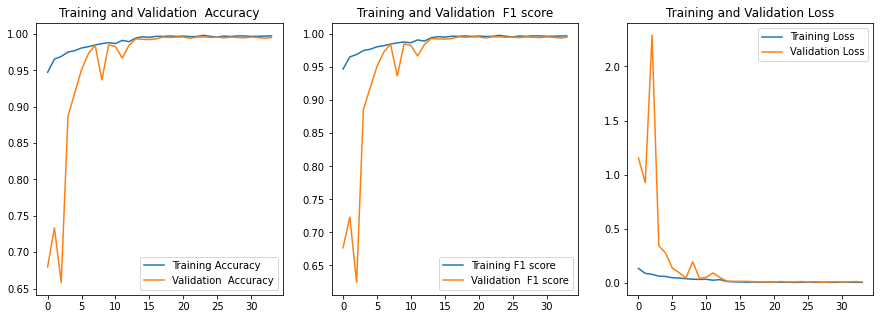

In [13]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss'])) 

plt.figure(figsize = (15,5))
plt.subplot(1, 3,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation  Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation  Accuracy')
    
plt.subplot(1, 3,2)
plt.plot(epochs_range, f1, label='Training F1 score')
plt.plot(epochs_range, val_f1, label='Validation  F1 score')
plt.legend(loc='lower right')
plt.title('Training and Validation  F1 score')
    
plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [14]:
MODEL_PATH = './best_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)

In [15]:
TEST_PATH = "../input/fake-image-classification-challenge/data/"
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
   )
test_ds = test_datagen.flow_from_directory(
                      TEST_PATH,classes=['test'],
                      target_size = (HEIGHT,WIDTH),
                      shuffle = False,
                      batch_size = BATCH_SIZE
                       )

Found 13500 images belonging to 1 classes.


In [16]:
test_dir = pd.read_csv('../input/fake-image-classification-challenge/data/test.csv')

In [17]:
pred = model.predict(test_ds)
predictions = [np.argmax(i) for i in pred]

In [18]:
dic = {1:"real", 0:"fake"}

predictions = [dic.get(n, n) for n in predictions]

In [19]:
test_df = pd.DataFrame(test_dir, columns = ["path"])
test_df["label"] = predictions
test_df.to_csv('./submission.csv',index=False)
test_df.head()

,path,label
0,data/test/00000.jpg,real
1,data/test/00001.jpg,fake
2,data/test/00002.jpg,fake
3,data/test/00003.jpg,real
4,data/test/00004.jpg,fake
